# Satellite Spatiotemporal Fusion Approaches to Monitor River Sediment Dynamics - HUC 05

### Elisa Friedmann
### May 2022



# Random Forest Model Exploration to learn sediment concentration from reflectance 

In [1]:
import os
os.getcwd()

'/nas/cee-water/cjgleason/ellie/SNiP/RFmodel'

In [2]:
import numpy as np
import pandas as pd
from numpy import mean, arange
from numpy import std
import pprint
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
import plotly
import plotly.express as px
import sklearn
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold
from sklearn import ensemble, datasets, tree
from sklearn.tree import plot_tree
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from collections import OrderedDict
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

In [3]:
from platform import python_version
print(python_version())

3.10.6


# Explore and Visualize the Data 

In [4]:
#bring in data

aquaHuc5 = pd.read_csv(r'aquasat_huc5_ratio.csv')

print(aquaHuc5.columns.values.tolist())
print(type(aquaHuc5))
print(aquaHuc5.SiteID.unique())#values.tolist())

['Unnamed: 0.1', 'Unnamed: 0', 'X_1', 'parameter', 'units', 'SiteID', 'lat', 'long', 'datum', 'value', 'particle_size', 'date', 'time_x', 'date_time', 'hydroCondition', 'hydroEvent', 'X', 'system_index', 'SiteID_y', 'blue', 'blue_sd', 'date_unity', 'green', 'green_sd', 'nir', 'nir_sd', 'path', 'pixelCount', 'qa', 'qa_sd', 'red', 'red_sd', 'row', 'sat', 'swir1', 'swir1_sd', 'swir2', 'swir2_sd', '_geo', 'endtime', 'date_only', 'chl_a', 'doc', 'p_sand', 'secchi', 'tis', 'tss', 'source', 'TZID', 'date_utc', 'clouds', 'time_y', 'landsat_id', 'timediff', 'pwater', 'type', 'id', 'NR', 'BR', 'GR', 'SR', 'BG', 'RG', 'NG', 'SG', 'BN', 'GN', 'RN', 'SN', 'BS', 'GS', 'RS', 'NS', 'R_GN', 'R_GB', 'R_GS', 'R_BN', 'R_BS', 'R_NS', 'G_BR', 'G_BN', 'G_BS', 'G_RN', 'G_RB', 'G_NS', 'B_RG', 'B_RN', 'B_RS', 'B_GN', 'B_GS', 'B_NS', 'N_RG', 'N_RB', 'N_RS', 'N_GB', 'N_GS', 'N_BS', 'GR2', 'GN2', 'BR_G', 'NS_NR', 'fai', 'N_S', 'N_R', 'ndvi', 'ndwi', 'ndssi', 'gn_gn']
<class 'pandas.core.frame.DataFrame'>
['USGS-03

380


[Text(0.5, 1.0, 'Aquasat Huc5 TSS vs Red Reflectance'), (0.0, 4000.0)]

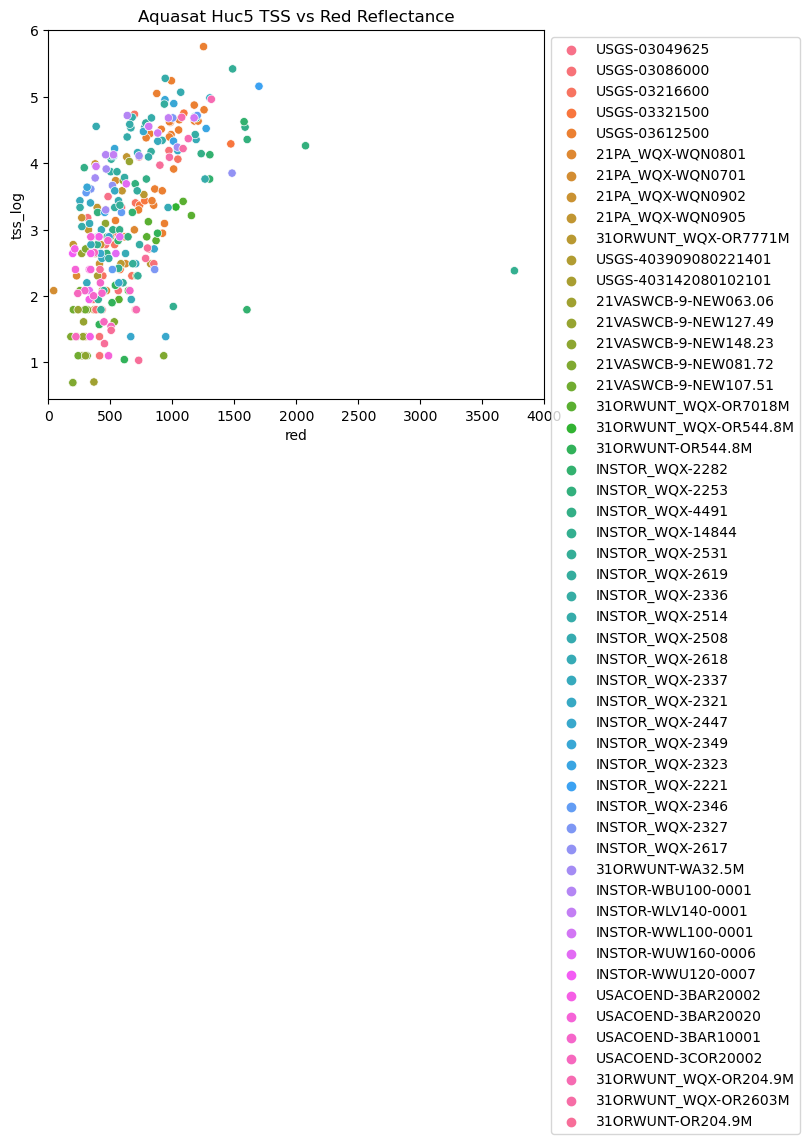

In [5]:
aquaHuc5 = aquaHuc5.drop_duplicates(subset=['SiteID', 'date', 'tss'])
print(len(aquaHuc5.index))
aquaHuc5['tss_log'] = np.log(aquaHuc5['tss'])
aquaHuc5['year'] = pd.to_datetime(aquaHuc5['date']).dt.year
aquaHuc5['month'] = pd.to_datetime(aquaHuc5['date']).dt.month
aquaHuc5 = aquaHuc5[aquaHuc5['date_utc'] > '2000-01-01T00:00:00Z']
#aquaHuc5 = aquaHuc5.groupby("SiteID")#.filter(lambda x: len(x) > 5)
#print(aquaHuc5.SiteID.values.tolist())

plot = sns.scatterplot(data=aquaHuc5, x="red", y="tss_log", 
                       legend = 'brief', hue="SiteID")
plt.legend(fontsize='6')
sns.move_legend(plot, "upper left", bbox_to_anchor=(1, 1))
plot.set(title='Aquasat Huc5 TSS vs Red Reflectance', xlim =(0,4000))

In [6]:
df = aquaHuc5[aquaHuc5['SiteID'] == 'INSTOR_WQX-2282']#'USGS-03086000',INSTOR_WQX-2221 #'USGS-03049625'
#df = df[df['date'] > '1/01/2000']
print(df.sort_values(by = 'date_utc').date)

263    2/18/2004
192     6/8/2004
231    3/16/2005
224    2/22/2006
247    3/13/2007
250     5/1/2007
Name: date, dtype: object


# Model

In [7]:
aquaHuc5 = pd.read_csv(r'aquasat_huc5_ratio.csv')
aquaHuc5 = aquaHuc5.drop_duplicates(subset=['SiteID', 'date', 'tss'])

# Clean data

I will only use data with greater than 10 measurements at each site to start. I will also dop any rows that have NaN TSS values.

In [8]:
#Clean data
df = aquaHuc5
df = df[df['units'] == 'mg/l']
df = df.groupby('SiteID').filter(lambda x: len(x) > 5)

df = df.dropna(subset=['tss'])


df = df[(df.red > 0) & (df.nir > 0) & (df.blue > 0) & (df.green > 0) & (df.swir1 > 0) & (df.swir2 > 0) & (df.nir < 6000)]


print(df.tss.describe())
print(df.columns.values.tolist())

count    239.000000
mean      46.649372
std       40.929965
min        2.800000
25%       14.000000
50%       33.000000
75%       69.000000
max      226.000000
Name: tss, dtype: float64
['Unnamed: 0.1', 'Unnamed: 0', 'X_1', 'parameter', 'units', 'SiteID', 'lat', 'long', 'datum', 'value', 'particle_size', 'date', 'time_x', 'date_time', 'hydroCondition', 'hydroEvent', 'X', 'system_index', 'SiteID_y', 'blue', 'blue_sd', 'date_unity', 'green', 'green_sd', 'nir', 'nir_sd', 'path', 'pixelCount', 'qa', 'qa_sd', 'red', 'red_sd', 'row', 'sat', 'swir1', 'swir1_sd', 'swir2', 'swir2_sd', '_geo', 'endtime', 'date_only', 'chl_a', 'doc', 'p_sand', 'secchi', 'tis', 'tss', 'source', 'TZID', 'date_utc', 'clouds', 'time_y', 'landsat_id', 'timediff', 'pwater', 'type', 'id', 'NR', 'BR', 'GR', 'SR', 'BG', 'RG', 'NG', 'SG', 'BN', 'GN', 'RN', 'SN', 'BS', 'GS', 'RS', 'NS', 'R_GN', 'R_GB', 'R_GS', 'R_BN', 'R_BS', 'R_NS', 'G_BR', 'G_BN', 'G_BS', 'G_RN', 'G_RB', 'G_NS', 'B_RG', 'B_RN', 'B_RS', 'B_GN', 'B_GS', 'B_

There is a large spread of the data though most values are low.

In [9]:
print('There are', df.SiteID.nunique(), 'unique sites')

There are 29 unique sites


In [10]:
#Add a transformation

df['R_GB_log'] = np.log(df['R_GB'])
df['tss_log'] = np.log(df['tss'])
df['date'] = pd.to_datetime(df.date)
df['year'] = pd.to_datetime(df['date']).dt.year
df['month'] = pd.to_datetime(df['date']).dt.month

In [11]:
df[['blue', 'blue_sd', 'green', 'green_sd', 'nir', 'nir_sd', 'red', 'red_sd', 'swir1', 'swir1_sd', 'swir2', 'swir2_sd']].describe()


,blue,blue_sd,green,green_sd,nir,nir_sd,red,red_sd,swir1,swir1_sd,swir2,swir2_sd
count,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.00000,239.000000,239.000000,239.000000
mean,542.603198,33.821238,742.564971,39.402319,647.644351,67.342565,683.236402,43.239408,247.68658,67.473127,165.372385,59.685355
std,309.509453,37.195993,318.729288,38.254483,353.533385,95.863873,373.097431,43.403606,192.62614,96.262411,144.644005,71.495200
min,173.000000,0.000000,274.000000,0.000000,109.000000,0.000000,201.000000,0.000000,50.00000,0.000000,26.000000,0.000000
25%,380.000000,16.901479,546.750000,20.683028,383.500000,31.297657,424.500000,20.991001,138.50000,30.778205,85.000000,28.495689
50%,497.000000,25.758364,686.000000,29.558438,568.000000,45.278459,580.000000,31.055953,200.00000,44.628043,122.000000,43.281199
75%,615.500000,35.005999,893.750000,42.326704,835.000000,70.545085,843.000000,46.077129,273.00000,66.306307,188.500000,59.435941
max,2962.000000,282.003262,2795.000000,265.854049,2659.000000,1042.261503,2796.000000,288.784964,1590.00000,920.572952,1096.000000,637.436930


<AxesSubplot:xlabel='date', ylabel='G_RN'>

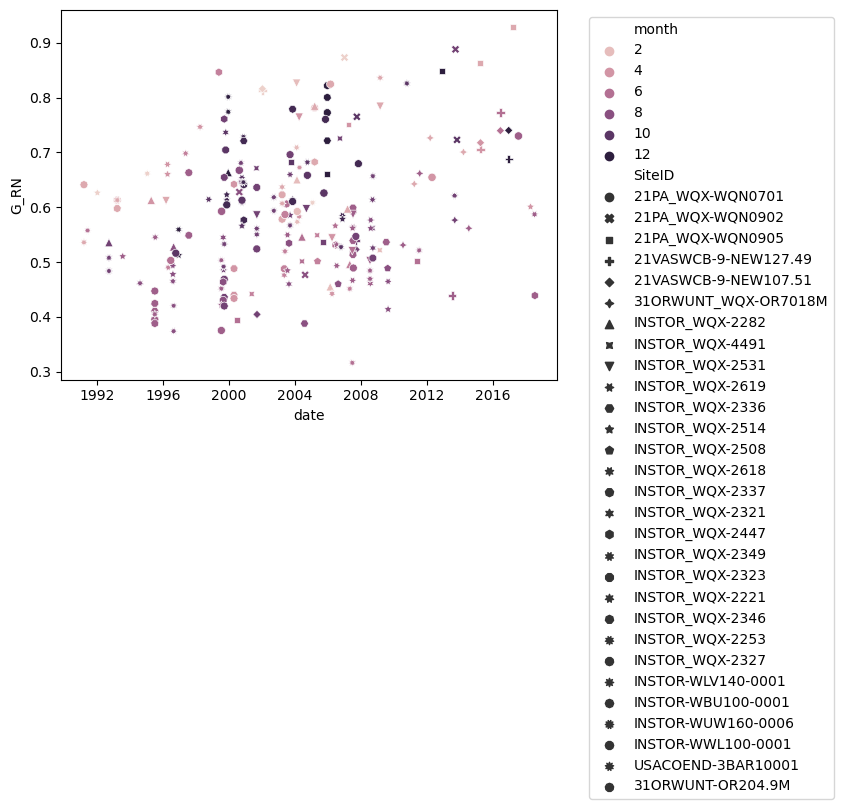

In [12]:
#Generate a first look Plot
plot = sns.scatterplot(data=df, x="date", y="G_RN", hue="month", style = 'SiteID')
plt.legend(fontsize='6')

sns.move_legend(plot, "upper left", bbox_to_anchor=(1.05, 1))
plot

# Define a Training and Testing Set



In [13]:
#define a training and testing set


df= df[['NR', 'BR', 'GR', 'SR', 'BG', 'RG', 'NG', 'SG', 'BN', 'GN', 'RN', 'SN', 'BS', 'GS', 'RS', 'NS', 'R_GN', 'R_GB', 'R_GS', 'R_BN', 'R_BS', 'R_NS', 'G_BR', 'G_BN', 'G_BS', 'G_RN', 'G_RB', 'G_NS', 'B_RG', 'B_RN', 'B_RS', 'B_GN', 'B_GS', 'B_NS', 'N_RG', 'N_RB', 'N_RS', 'N_GB', 'N_GS', 'N_BS', 'GR2', 'GN2', 'BR_G', 'NS_NR', 'fai', 'N_S', 'N_R', 'ndssi', 'gn_gn', 'R_GB_log', 'tss_log']].dropna(axis=0) #dropping na just in case here again

# Arrange Data into Features Matrix and Target Vector
X = df.loc[:, df.columns != 'tss_log']
y = df.loc[:, 'tss_log'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

# summarize the dataset
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

#define model
model = RandomForestRegressor(bootstrap = True, oob_score= True, random_state = 42)

(191, 50)
(48, 50)
(191,)
(48,)


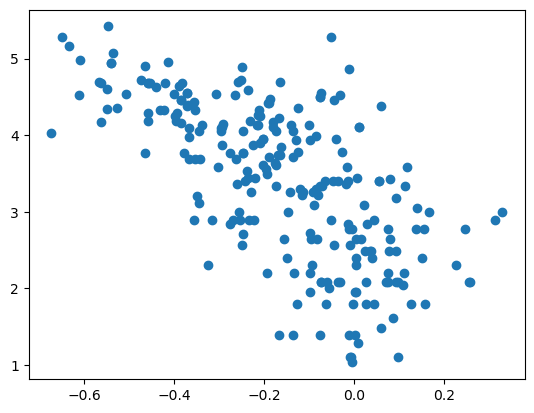

In [14]:
#Generate Plot
import matplotlib.pyplot as plt
scatter = plt.scatter(x=df['BR_G'], y=df["tss_log"])
scatter

# Random Forest 1: No fit

Target: TSS

Input Data: 6 Bands and their ratios

In [15]:
#Quick eval raw
model.fit(X_train, y_train)
print('Trained model oob score', model.oob_score_)

prediction = model.predict(X_test)

Trained model oob score 0.6740438391406705


In [16]:
#Metrics for Model 1 

RMSE_model = np.sqrt(mean_squared_error(y_test, prediction))

#Metrics
print('Training score', model.score(X_train, y_train))
print('RMSE', RMSE_model)
print('Testing score', model.score(X_test, y_test))

Training score 0.9560860432470558
RMSE 0.7833425984959127
Testing score 0.40275509546312016


There is a large difference between training and testing scores. The RMSE is also large given the average values of TSS but it is within the standard deviation of the data.

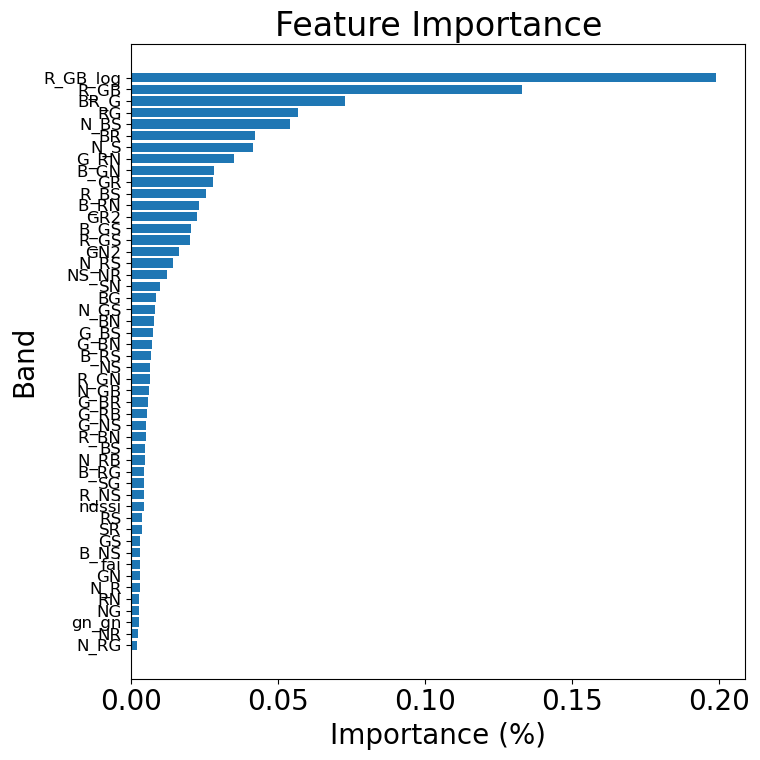

In [17]:
#Feature importance
import numpy as np
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
#
# Get Feature importance data using feature_importances_ attribute
plt.rcParams.update({'font.size': 20})
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(8, 8))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.ylabel('Band')
plt.xlabel('Importance (%)')
plt.yticks(pos, np.array(X.columns)[sorted_idx], size = 12)
plt.title('Feature Importance')
result = permutation_importance(model, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
fig.tight_layout()
plt.show()



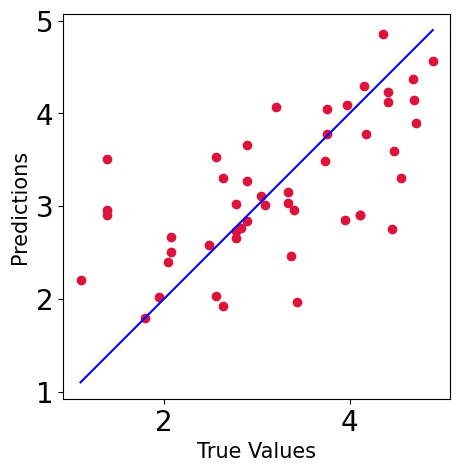

In [18]:
plt.figure(figsize=(5,5))
plt.scatter(y_test, prediction, c='crimson')

p1 = max(max(prediction), max(y_test))
p2 = min(min(prediction), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

# Optimizing the Random Forest

## I will optimize:

max_features

n_estimators

max_depth


In [19]:
###takes a lot of time. See results below.

from sklearn.model_selection import GridSearchCV

estimator = RandomForestRegressor(bootstrap = True, oob_score= True, random_state = 42, verbose = 0)
param_grid = {
            "n_estimators" : [100, 150, 200, 300],
            "max_features" : ["1.0", "log2", "sqrt"],
            "max_depth"    : [1, 4, 7, 8, 10]
        }


grid = GridSearchCV(estimator=estimator, param_grid=param_grid, cv= 5, verbose =0)
grid.fit(X_train, y_train)


forest = grid.best_estimator_

grid_prediction=forest.predict(X_test)

print ('Grid best score:', grid.best_score_, 'Grid best params:', grid.best_params_)

mae_grid = mean_absolute_error(y_test, grid_prediction)
RMSE_model_grid = np.sqrt(mean_squared_error(y_test, grid_prediction))

print('MAE:', mae_grid)
print('RMSE:', RMSE_model_grid)

/work/efriedmann_umass_edu/.conda/envs/fusion_SNiP/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
100 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
100 fits failed with the following error:
Traceback (most recent call last):
  File "/work/efriedmann_umass_edu/.conda/envs/fusion_SNiP/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/work/efriedmann_umass_edu/.conda/envs/fusion_SNiP/lib/python3.10/site-packages/sklearn/ensemble/_forest.py", line 476, in fit
    trees = Parallel(
  File "/work/efriedmann_umass_edu/.conda/envs/fusion_SNiP/lib/python3.10/si

Grid best score: 0.6683339161494973 Grid best params: {'max_depth': 10, 'max_features': 'log2', 'n_estimators': 300}
MAE: 0.5969837903729908
RMSE: 0.7928370773419192


Grid best score: 0.7204301629272072 Grid best params: {'max_depth': 10, 'max_features': 'log2', 'n_estimators': 150}
MAE: 0.323724944699268
RMSE: 0.5263227339501133

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

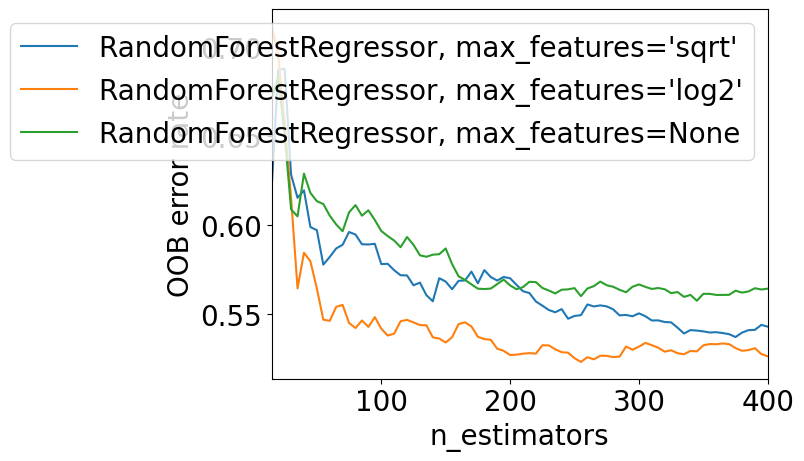

In [20]:
#Optimize RF
#OPtimize max_features and n_estimators using oob_score


#plot ensemble oob

# Author: Kian Ho <hui.kian.ho@gmail.com>
#         Gilles Louppe <g.louppe@gmail.com>
#         Andreas Mueller <amueller@ais.uni-bonn.de>
#
# License: BSD 3 Clause

RANDOM_STATE = 42

# NOTE: Setting the `warm_start` construction parameter to `True` disables
# support for parallelized ensembles but is necessary for tracking the OOB
# error trajectory during training.
ensemble_clfs = [
    (
        "RandomForestRegressor, max_features='sqrt'",
        RandomForestRegressor(
            bootstrap=True,
            warm_start=True,
            oob_score=True,
            verbose =1,
            max_features=3,
            random_state=RANDOM_STATE,
        ),
    ),
    (
        "RandomForestRegressor, max_features='log2'",
        RandomForestRegressor(
            bootstrap=True,
            warm_start=True,
            max_features="log2",
            oob_score=True,
            verbose =1,
            random_state=RANDOM_STATE,
        ),
    ),
    (
        "RandomForestRegressor, max_features=None",
        RandomForestRegressor(
            bootstrap=True,
            warm_start=True,
            max_features=None,
            oob_score=True,
            verbose = 1,
            random_state=RANDOM_STATE,
        ),
    ),
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 15
max_estimators = 400

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1, 5):
        clf.set_params(n_estimators=i)
        clf.fit(X_test, y_test)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

Processed Regression Tree (depth=1)
Processed Regression Tree (depth=2)
Processed Regression Tree (depth=3)
Processed Regression Tree (depth=4)
Processed Regression Tree (depth=5)
Processed Regression Tree (depth=6)
Processed Regression Tree (depth=7)
Processed Regression Tree (depth=8)
Processed Regression Tree (depth=9)
Processed Regression Tree (depth=10)
Processed Regression Tree (depth=11)
Processed Regression Tree (depth=12)
Processed Regression Tree (depth=13)
Processed Regression Tree (depth=14)
Processed Regression Tree (depth=15)


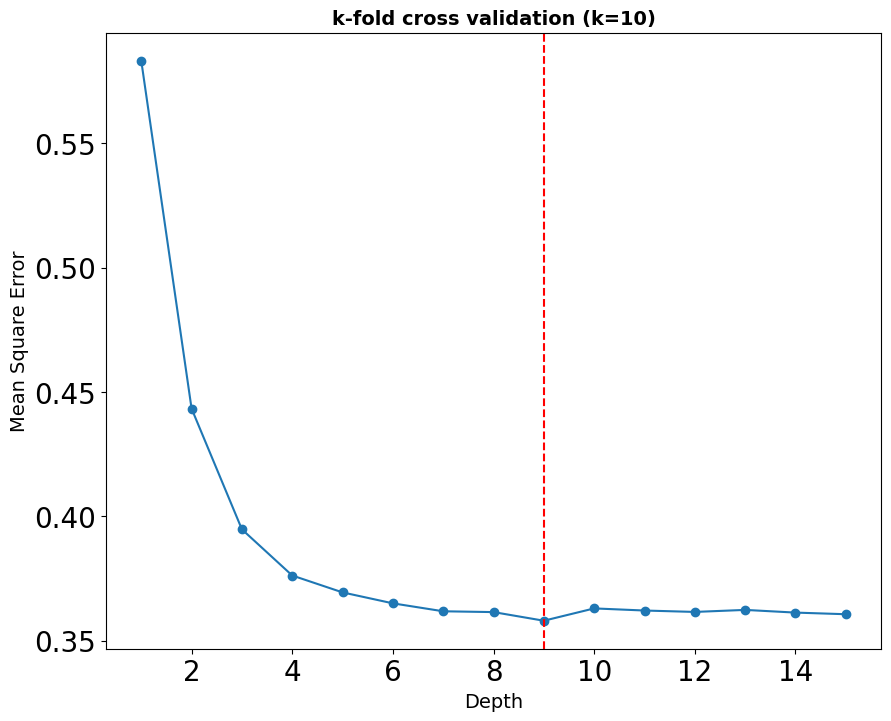

In [21]:
# Setup evaluation with 10-fold cv
k_fold = 10
dep = np.arange(1,15+1)

scores = []
for i in dep:
    cv = cross_val_score(RandomForestRegressor(random_state=42,max_depth=i), X_train, y_train,\
         cv=k_fold, scoring='neg_mean_squared_error').mean()
    scores.append(cv)
    print(f'Processed Regression Tree (depth={i})')
best = dep[np.argmin(np.array(scores)*-1)]

plt.figure(figsize=(10,8))
plt.plot(dep, np.array(scores)*-1, '-o')
plt.axvline(best, color = 'r', ls="--")
plt.xlabel('Depth',fontsize=14)
plt.ylabel('Mean Square Error',fontsize=14)
plt.title(f'k-fold cross validation (k={k_fold})',fontsize=14, fontweight='bold')
plt.show()

Processed Regression Tree (depth=0.0)


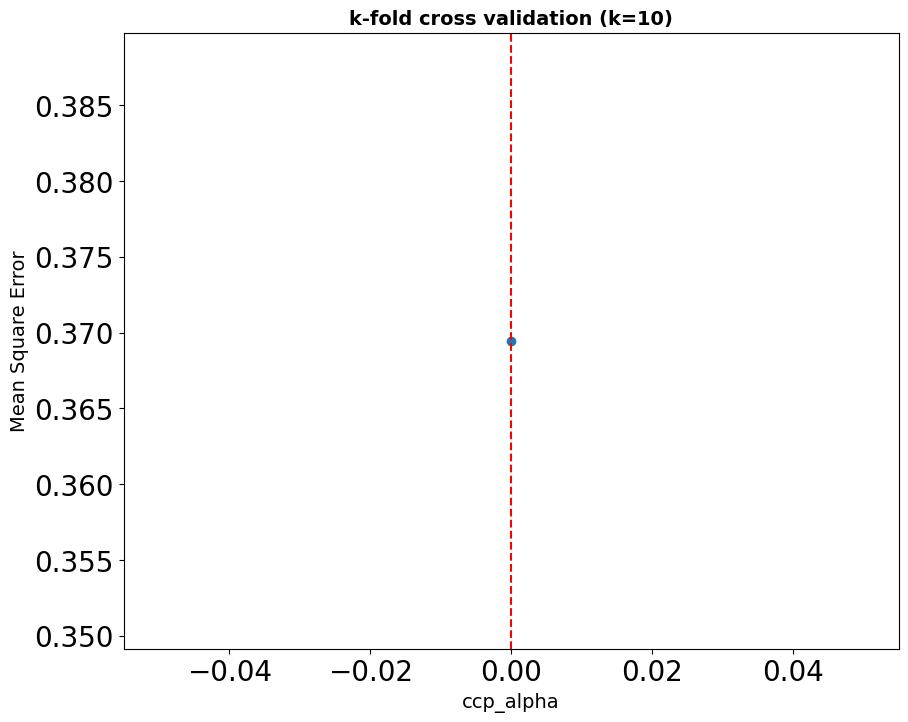

In [22]:
# Setup evaluation with 10-fold cv
k_fold = 10
dep = np.arange(0,0.1,100)

scores = []
for i in dep:
    cv = cross_val_score(RandomForestRegressor(random_state=42,max_depth=5, ccp_alpha =i), X_train, y_train, cv=k_fold, scoring='neg_mean_squared_error').mean()
    scores.append(cv)
    print(f'Processed Regression Tree (depth={i})')
best = dep[np.argmin(np.array(scores)*-1)]

plt.figure(figsize=(10,8))
plt.plot(dep, np.array(scores)*-1, '-o')
plt.axvline(best, color = 'r', ls="--")
plt.xlabel('ccp_alpha',fontsize=14)
plt.ylabel('Mean Square Error',fontsize=14)
plt.title(f'k-fold cross validation (k={k_fold})',fontsize=14, fontweight='bold')
plt.show()

## Badly fit ccp_alpha

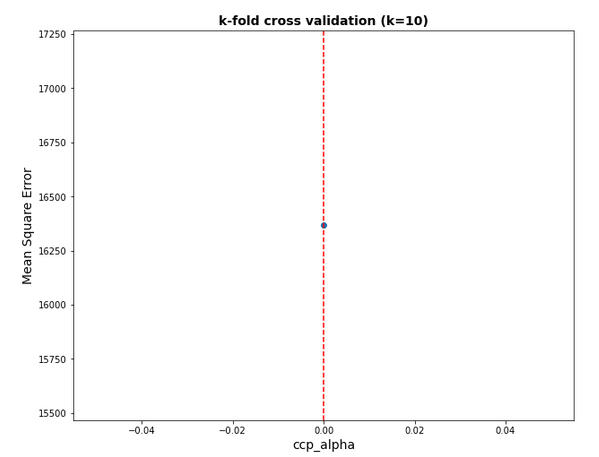

# Model with some fitted params

In [23]:

#define model
model1 = RandomForestRegressor(max_depth = 13, n_estimators = 175, min_samples_split = 2, max_features = 'sqrt', bootstrap = True, oob_score= True, warm_start = False, ccp_alpha = 0, min_impurity_decrease = 0)

In [24]:
#Quick eval raw
model1.fit(X_train, y_train)
print('Trained model oob score', 1 - model1.oob_score_)

prediction1 = model1.predict(X_test)
print('Test Score', model1.score(X_test, y_test))

Trained model oob score 0.3234204425636751
Test Score 0.3461402841901795


In [25]:
#Test Error: Model 1 RMSE
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

#TEST

RMSE_model1 = np.sqrt(mean_squared_error(y_test, prediction1))

#Metrics
print('Training score', model1.score(X_train, y_train))
print('RMSE', RMSE_model1)
print('Testing score', model1.score(X_test, y_test))

Training score 0.9567185195773282
RMSE 0.8196299289803333
Testing score 0.3461402841901795


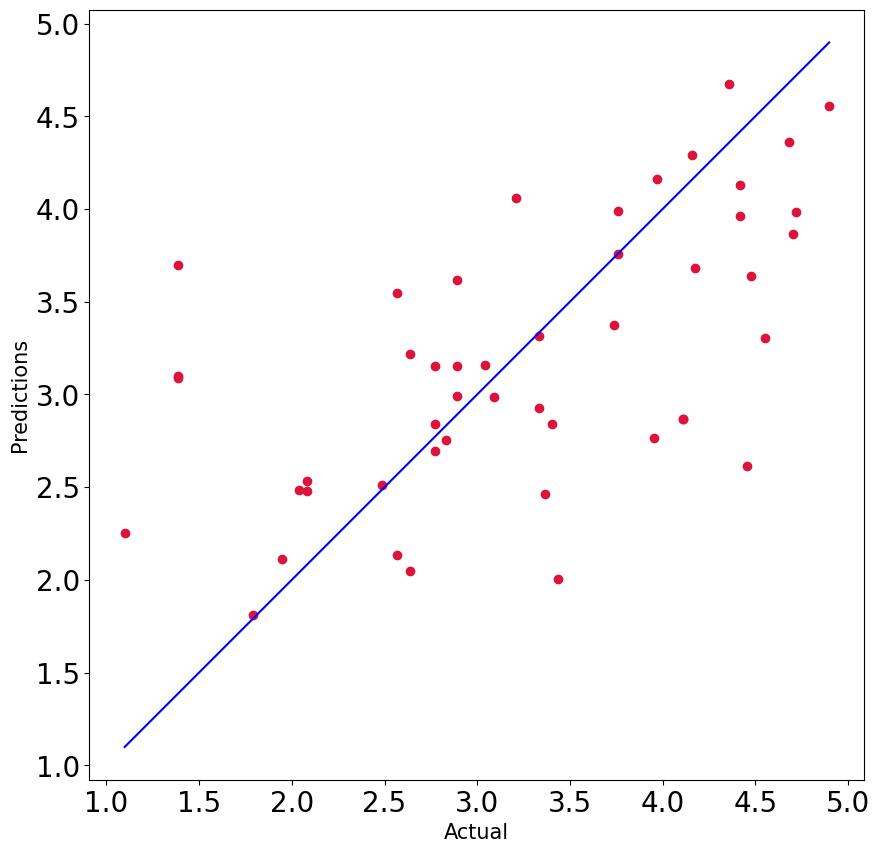

In [26]:
plt.figure(figsize=(10,10))
plt.scatter(y_test, prediction1, c='crimson')

p1 = max(max(prediction1), max(y_test))
p2 = min(min(prediction1), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('Actual', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

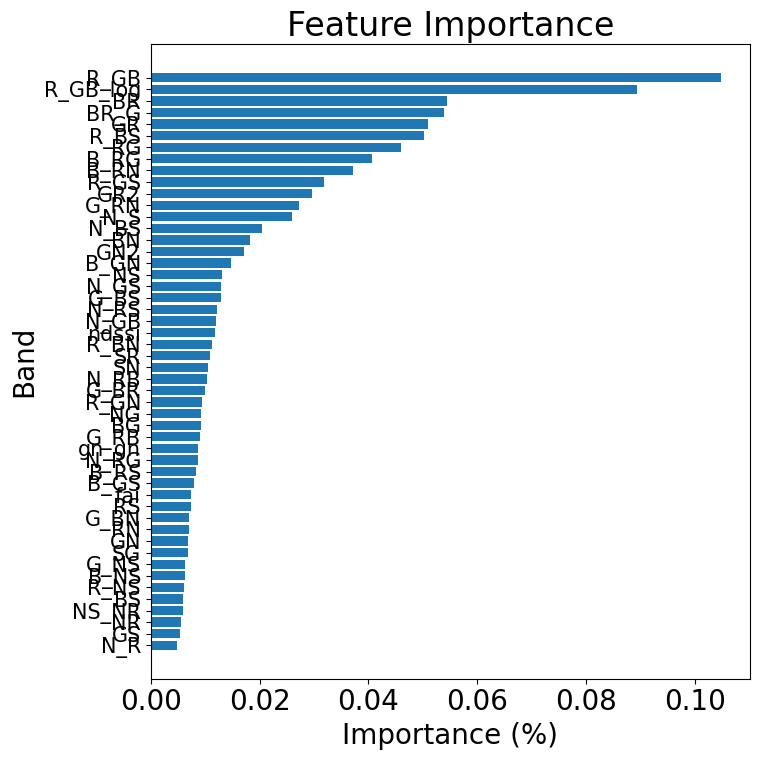

In [27]:
#Feature importance
import numpy as np
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
#
# Get Feature importance data using feature_importances_ attribute
plt.rcParams.update({'font.size': 20})
feature_importance = model1.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(8, 8))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.ylabel('Band')
plt.xlabel('Importance (%)')
plt.yticks(pos, np.array(X.columns)[sorted_idx], size = 15)
plt.title('Feature Importance')
result = permutation_importance(model1, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
fig.tight_layout()
plt.show()


  Metric   RF1   RF2
0    MAE  0.16  0.16
1   RMSE  0.21  0.21


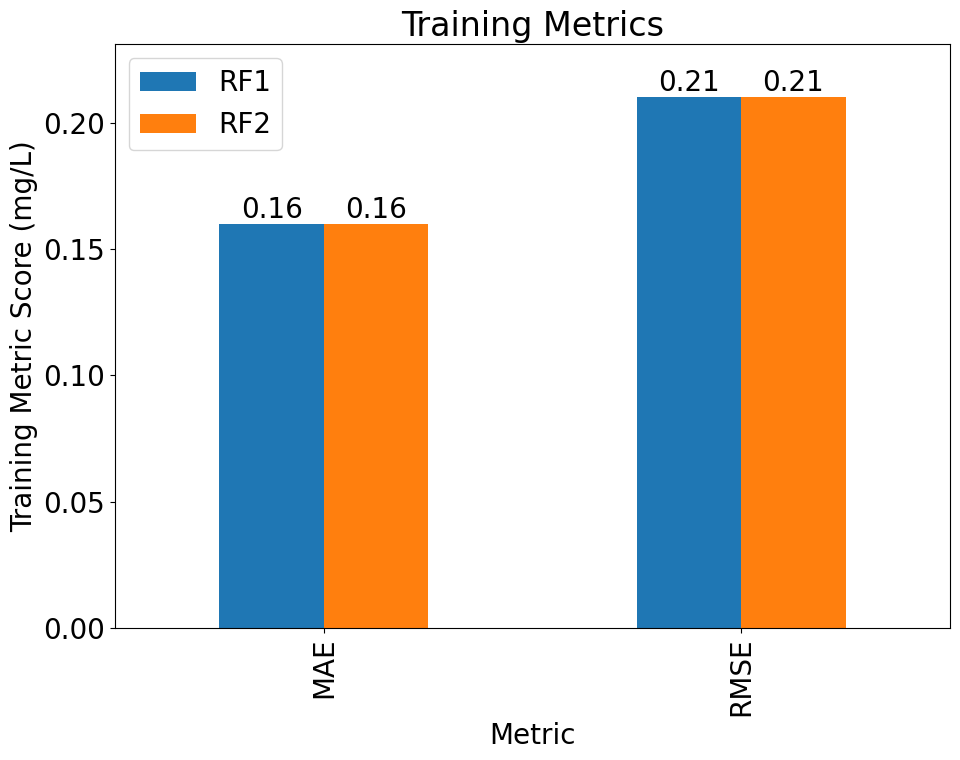

In [28]:
#Collect the test set predictions for d-h models

model_pred = model.predict(X_test)
model1_pred = model1.predict(X_test)


# Keep predictions of models d-h
model_train_pred = [model.predict(X_train),model1.predict(X_train)]

model_test_pred = [model.predict(X_test),model1.predict(X_test)]

# predicted MAE and MSE for training data

models_MAE = []
for i in model_train_pred:
    MAE = np.round(mean_absolute_error(y_train, i),2)
    models_MAE.append(MAE)

models_RMSE = []
for i in model_train_pred:
    RMSE = np.round(np.sqrt(mean_squared_error(y_train, i)),2)
    models_RMSE.append(RMSE)

    
# Plot
mod_names=['RF1', 'RF2']
metric=pd.DataFrame(['MAE','RMSE'],columns=['Metric'])
df = pd.concat([metric,pd.DataFrame([models_MAE,models_RMSE],columns=mod_names)],axis=1)

print(df.head())

ax = df.plot(x="Metric", y=mod_names, kind="bar", title = 'Training Metrics', figsize=(10,8))
# annotate
ax.bar_label(ax.containers[0], label_type='edge')
ax.bar_label(ax.containers[1], label_type='edge')
# pad the spacing between the number and the edge of the figure
ax.margins(y=0.1)
plt.ylabel('Training Metric Score (mg/L)')
plt.tight_layout()
plt.show()

  Metric   RF1   RF2
0    MAE  0.59  0.61
1   RMSE  0.78  0.82


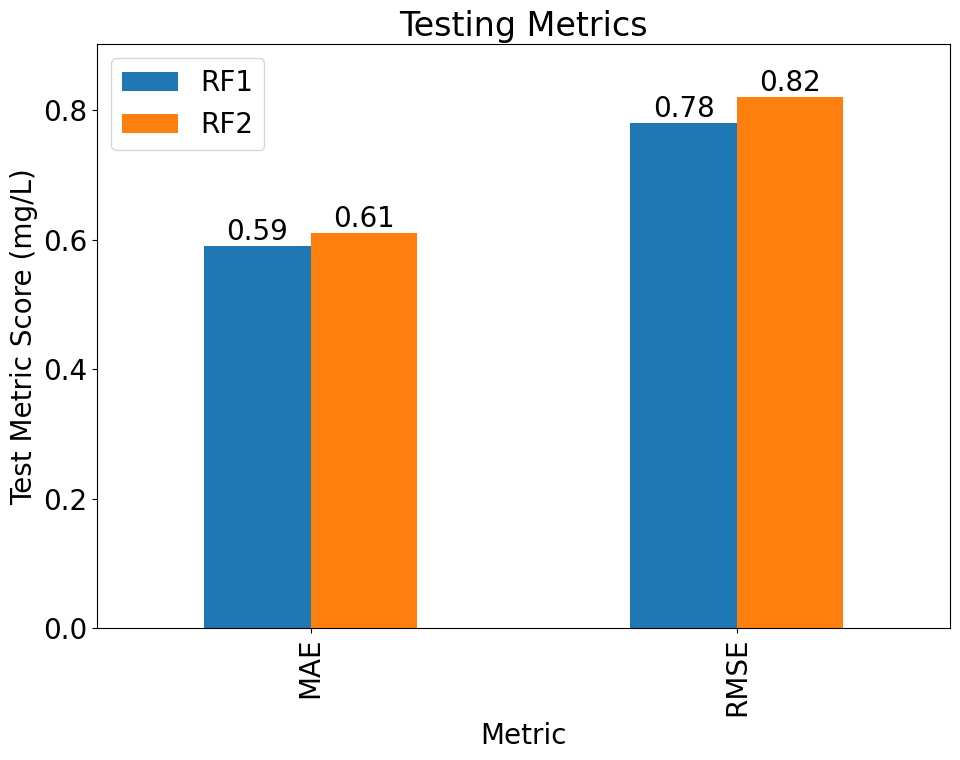

In [29]:
#Predict MAE and RMSE for test data

models_MAE_test = []
for i in model_test_pred:
    MAE = np.round(mean_absolute_error(y_test, i),2)
    models_MAE_test.append(MAE)

models_RMSE_test = []
for i in model_test_pred:
    RMSE = np.round(np.sqrt(mean_squared_error(y_test, i)),2)
    models_RMSE_test.append(RMSE)

# Plot
df = pd.concat([metric,pd.DataFrame([models_MAE_test,models_RMSE_test],columns=mod_names)],axis=1)

print(df.head())

ax = df.plot(x="Metric", y=mod_names, kind="bar", title = 'Testing Metrics', figsize=(10,8))
# annotate
ax.bar_label(ax.containers[0], label_type='edge')
ax.bar_label(ax.containers[1], label_type='edge')
# pad the spacing between the number and the edge of the figure
ax.margins(y=0.1)
plt.ylabel('Test Metric Score (mg/L)')
plt.tight_layout()
plt.show()

In [30]:
# plot the tree
# fn=X.columns
# cn= 'tss'
# fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (8,8), dpi=800)
# tree.plot_tree(model1.estimators_[0],
#                feature_names = fn, 
#                class_names=cn,
#                filled = True);
# fig.savefig('rf_individualtree.png')

#Visualize multiple trees
# This may not the best way to view each estimator as it is small
# fn=data.feature_names
# cn=data.target_names
# fig, axes = plt.subplots(nrows = 1,ncols = 5,figsize = (10,2), dpi=900)
# for index in range(0, 5):
#     tree.plot_tree(rf.estimators_[index],
#                    feature_names = fn, 
#                    class_names=cn,
#                    filled = True,
#                    ax = axes[index]);

#     axes[index].set_title('Estimator: ' + str(index), fontsize = 11)
# fig.savefig('rf_5trees.png')